# AI System Implementation - Exploring difference approches

- dataset: food101

## Importing Library

In [1]:
import os
import math
import time
import random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

2025-03-10 13:02:58.496493: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-10 13:02:58.496625: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-10 13:02:58.496684: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-10 13:02:59.962886: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Variables

In [2]:
# Define dataset path (Modify this if needed)
DATASET_PATH = f"food-101/images"  # Change this to your dataset location

In [3]:
CLASSES = 5
BATCH_SIZE = 32
EPOCHES = 100
SEED = 42
VALID = 0.1
TEST = 0.1

# Get class names (folder names)
classes = os.listdir(DATASET_PATH)
selected_classes = classes[:CLASSES]  # Select first 10 classes

In [4]:
# Set random seed for reproducibility
random.seed(SEED)

## Visaulizing Sample Images

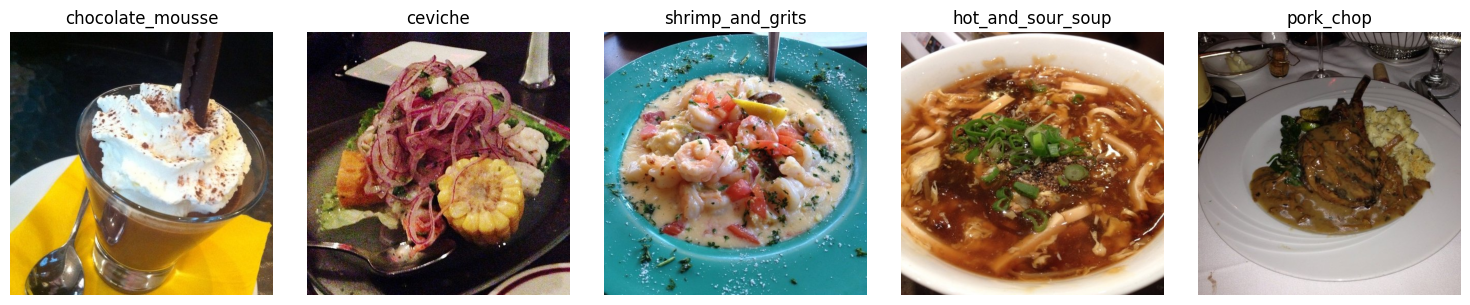

In [5]:
# Dynamically determine the grid size for plotting
cols = min(CLASSES, 5)  # Max 5 columns for better layout
rows = math.ceil(CLASSES / cols)

# Create visualization grid
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

# Flatten axes array for easy iteration
axes = axes.flatten() if CLASSES > 1 else [axes]

for i, class_name in enumerate(selected_classes):
    try:
        # Get a random image from the class
        image_file = random.choice(os.listdir(os.path.join(DATASET_PATH, class_name)))
        img_path = os.path.join(DATASET_PATH, class_name, image_file)
        img = plt.imread(img_path)

        # Display the image
        axes[i].imshow(img)
        axes[i].set_title(class_name)
        axes[i].axis('off')
    except Exception as e:
        print(f"Error loading image for {class_name}: {e}")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.tight_layout()  # Adjust layout for better spacing
plt.show()

## Utility Function

### Image

In [6]:
def get_image_shape(image_size, channels=3):
    return (image_size, image_size, channels)

In [7]:
def img_preprocessing():
    # Train Data Generator (80% of dataset)
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        validation_split=VALID + TEST  # Uses 20% for both validation + test
    )

    # Load Training Data (80%)
    train_generator = train_datagen.flow_from_directory(
        DATASET_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        subset="training",  # Uses 80% of dataset
        classes=selected_classes  # Loads only selected classes
    )

    # Validation Data Generator (Separate 10%)
    val_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=VALID  # Directly use VALID (10%)
    )

    val_generator = val_datagen.flow_from_directory(
        DATASET_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        subset="validation",  # Uses 10% of dataset
        shuffle=False,
        classes=selected_classes  # Loads only selected classes
    )

    # Test Data Generator (Separate 10%)
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=TEST  # Directly use TEST (10%)
    )

    test_generator = test_datagen.flow_from_directory(
        DATASET_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        subset="validation",  # Uses 10% of dataset
        shuffle=False,
        classes=selected_classes  # Loads only selected classes
    )

    return train_generator, val_generator, test_generator



### Model

In [8]:
def generate_model (pretraining_model, dense=256, dropout=0.6, learning_rate=1e-4):
  base_model = pretraining_model(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
  base_model.trainable = False

  # Add custom classification layers
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(dense, activation="relu")(x)
  x = Dropout(dropout)(x)

  output_layer = Dense(CLASSES, activation="softmax")(x)
  model = Model(inputs=base_model.input, outputs=output_layer)

  model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  model.summary()

  return base_model, model

def fine_tune_model (base_model, model, learning_rate=1e-5):
  base_model.trainable = True

  # Recompile model with lower learning rate
  model.compile(optimizer=Adam(learning_rate=learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

  return model

In [9]:
def fine_tune_model (base_model, model, learning_rate=1e-5):
  base_model.trainable = True

  # Recompile model with lower learning rate
  model.compile(optimizer=Adam(learning_rate=learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

  return model

In [10]:
def train_model (model, train_generator, val_generator):
  early_stopping = EarlyStopping(
    monitor="val_loss",  # Stop when validation loss stops improving
    patience=3,  # Wait 3 epochs before stopping
    restore_best_weights=True  # Keep the best model
  )

  lr_scheduler = ReduceLROnPlateau(
      monitor="val_loss",
      factor=0.5,  # Reduce by half
      patience=3,  # Wait 3 epochs
      min_lr=1e-6
  )

  # Train model
  start_time = time.time()
  # Train model with early stopping
  history = model.fit(
      train_generator, 
      validation_data=val_generator,
      epochs=EPOCHES,
      callbacks=[early_stopping, lr_scheduler]
  )
  end_time = time.time()
  training_time = end_time - start_time

  return history, training_time, model

### Graph

In [11]:
def plot_accuracy_n_loss(history):
    # Plot accuracy and loss graphs
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label="Train Accuracy")
    plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Validation Loss")
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

In [12]:
def gen_report(model, test_generator, history, fine_tune_history, initial_training_time, fine_tuning_time):
    """
    Generates evaluation report including classification report, confusion matrix, 
    accuracy/loss summary, and training times.

    Parameters:
    - model: Trained Keras model
    - test_generator: Test dataset generator
    - history: Training history before fine-tuning
    - fine_tune_history: Training history after fine-tuning
    - initial_training_time: Time taken for initial training
    - fine_tuning_time: Time taken for fine-tuning
    """

    # Extract true labels from test generator
    y_true = test_generator.classes  # Ground truth labels

    # Predict class probabilities and get predicted labels
    y_pred_probs = model.predict(test_generator, steps=len(test_generator), verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices

    # Get class labels from test generator
    class_labels = list(test_generator.class_indices.keys())  # Class names
    
    # Classification Report
    print("=== Classification Report ===")
    class_report = classification_report(y_true, y_pred, target_names=class_labels)
    print(class_report)

    # Calculate average accuracy and loss (before fine-tuning)
    avg_train_acc = np.mean(history.history['accuracy'])
    avg_val_acc = np.mean(history.history['val_accuracy'])
    avg_train_loss = np.mean(history.history['loss'])
    avg_val_loss = np.mean(history.history['val_loss'])

    # Calculate average accuracy and loss (after fine-tuning)
    avg_train_acc_fine = np.mean(fine_tune_history.history['accuracy'])
    avg_val_acc_fine = np.mean(fine_tune_history.history['val_accuracy'])
    avg_train_loss_fine = np.mean(fine_tune_history.history['loss'])
    avg_val_loss_fine = np.mean(fine_tune_history.history['val_loss'])

    # Display accuracy and loss results
    print("\n=== Initial Training Results ===")
    print(f"Average Training Accuracy: {avg_train_acc:.4f}")
    print(f"Average Validation Accuracy: {avg_val_acc:.4f}")
    print(f"Average Training Loss: {avg_train_loss:.4f}")
    print(f"Average Validation Loss: {avg_val_loss:.4f}")

    print("\n=== After Fine-Tuning Results ===")
    print(f"Average Training Accuracy (Fine-Tuned): {avg_train_acc_fine:.4f}")
    print(f"Average Validation Accuracy (Fine-Tuned): {avg_val_acc_fine:.4f}")
    print(f"Average Training Loss (Fine-Tuned): {avg_train_loss_fine:.4f}")
    print(f"Average Validation Loss (Fine-Tuned): {avg_val_loss_fine:.4f}")

    # Generate Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Display runtime performance
    print("\n=== Runtime Performance ===")
    print(f"Initial Training Time: {initial_training_time:.2f} seconds")
    print(f"Fine-Tuning Time: {fine_tuning_time:.2f} seconds")


## Model

### EfficientNet

#### B0

##### Build ModelArithmeticError

In [23]:
IMG_SIZE = 224
IMG_SHAPE = get_image_shape(IMG_SIZE)

In [24]:
from tensorflow.keras.applications import EfficientNetB0

base_model, model = generate_model(EfficientNetB0)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]'] 

##### Train Model (Before Fine-Tuning)

In [25]:
train_generator, val_generator, test_generator = img_preprocessing()

print(f"Train Samples: {train_generator.samples}")  # Expecting 80% of total images
print(f"Validation Samples: {val_generator.samples}")  # Expecting 10% of total images
print(f"Test Samples: {test_generator.samples}")  # Expecting 10% of total images

Found 4000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Train Samples: 4000
Validation Samples: 500
Test Samples: 500


In [26]:
history, initial_training_time, model = train_model(model, train_generator, val_generator)

Epoch 1/100
125/125 [==============================] - 108s 792ms/step - loss: 1.6358 - accuracy: 0.2007 - val_loss: 1.6121 - val_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 2/100
125/125 [==============================] - 97s 777ms/step - loss: 1.6174 - accuracy: 0.2013 - val_loss: 1.6119 - val_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 3/100
125/125 [==============================] - 95s 761ms/step - loss: 1.6139 - accuracy: 0.1985 - val_loss: 1.6101 - val_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 4/100
125/125 [==============================] - 109s 871ms/step - loss: 1.6117 - accuracy: 0.1985 - val_loss: 1.6094 - val_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 5/100
125/125 [==============================] - 95s 762ms/step - loss: 1.6098 - accuracy: 0.1978 - val_loss: 1.6095 - val_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 6/100
125/125 [==============================] - 95s 758ms/step - loss: 1.6101 - accuracy: 0.1975 - val_loss: 1.6096 - val_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 7/100
125/125 

###### Accuracy and Loss Graph

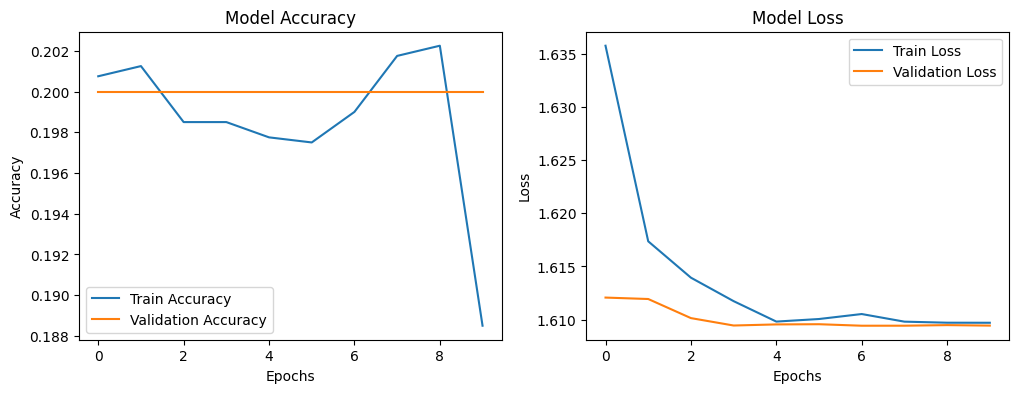

In [27]:
plot_accuracy_n_loss(history)

##### Fine-Tuning

In [28]:
model = fine_tune_model(base_model, model)

In [29]:
# Fine-tune model
fine_tune_history, fine_tuning_time, model = train_model(model, train_generator, val_generator)

Epoch 1/100
125/125 [==============================] - 302s 2s/step - loss: 1.6960 - accuracy: 0.2397 - val_loss: 1.6167 - val_accuracy: 0.1960 - lr: 1.0000e-05
Epoch 2/100
125/125 [==============================] - 262s 2s/step - loss: 1.4875 - accuracy: 0.3553 - val_loss: 1.6128 - val_accuracy: 0.1900 - lr: 1.0000e-05
Epoch 3/100
125/125 [==============================] - 262s 2s/step - loss: 1.3284 - accuracy: 0.4615 - val_loss: 1.5354 - val_accuracy: 0.2940 - lr: 1.0000e-05
Epoch 4/100
125/125 [==============================] - 265s 2s/step - loss: 1.1831 - accuracy: 0.5337 - val_loss: 1.2634 - val_accuracy: 0.5140 - lr: 1.0000e-05
Epoch 5/100
125/125 [==============================] - 266s 2s/step - loss: 1.0539 - accuracy: 0.6155 - val_loss: 0.9524 - val_accuracy: 0.7100 - lr: 1.0000e-05
Epoch 6/100
125/125 [==============================] - 266s 2s/step - loss: 0.9323 - accuracy: 0.6565 - val_loss: 0.8361 - val_accuracy: 0.7360 - lr: 1.0000e-05
Epoch 7/100
125/125 [=============

###### Accuracy and Loss Graph

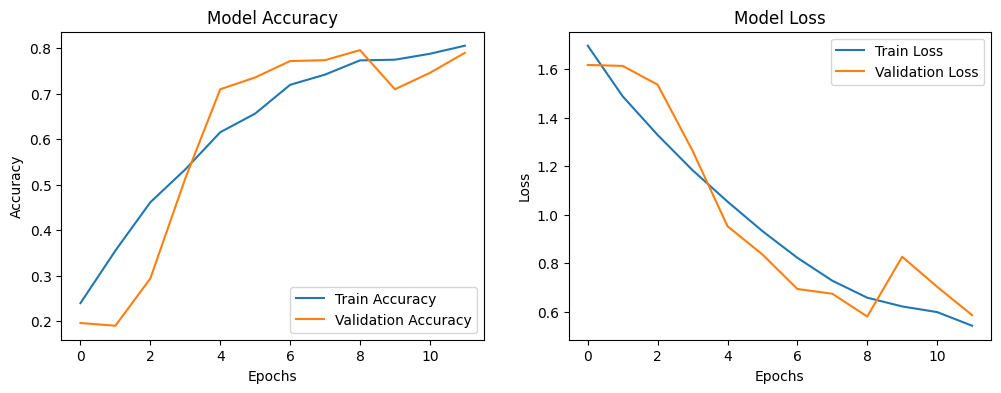

In [30]:
plot_accuracy_n_loss(fine_tune_history)

##### Evaluate Model

16/16 [==============================] - 9s 449ms/step
=== Classification Report ===
                   precision    recall  f1-score   support

 chocolate_mousse       0.81      0.93      0.87       100
          ceviche       0.86      0.71      0.78       100
 shrimp_and_grits       0.66      0.73      0.69       100
hot_and_sour_soup       0.93      0.83      0.88       100
        pork_chop       0.76      0.78      0.77       100

         accuracy                           0.80       500
        macro avg       0.80      0.80      0.80       500
     weighted avg       0.80      0.80      0.80       500


=== Initial Training Results ===
Average Training Accuracy: 0.1986
Average Validation Accuracy: 0.2000
Average Training Loss: 1.6138
Average Validation Loss: 1.6100

=== After Fine-Tuning Results ===
Average Training Accuracy (Fine-Tuned): 0.6222
Average Validation Accuracy (Fine-Tuned): 0.6023
Average Training Loss (Fine-Tuned): 0.9711
Average Validation Loss (Fine-Tuned): 0.9

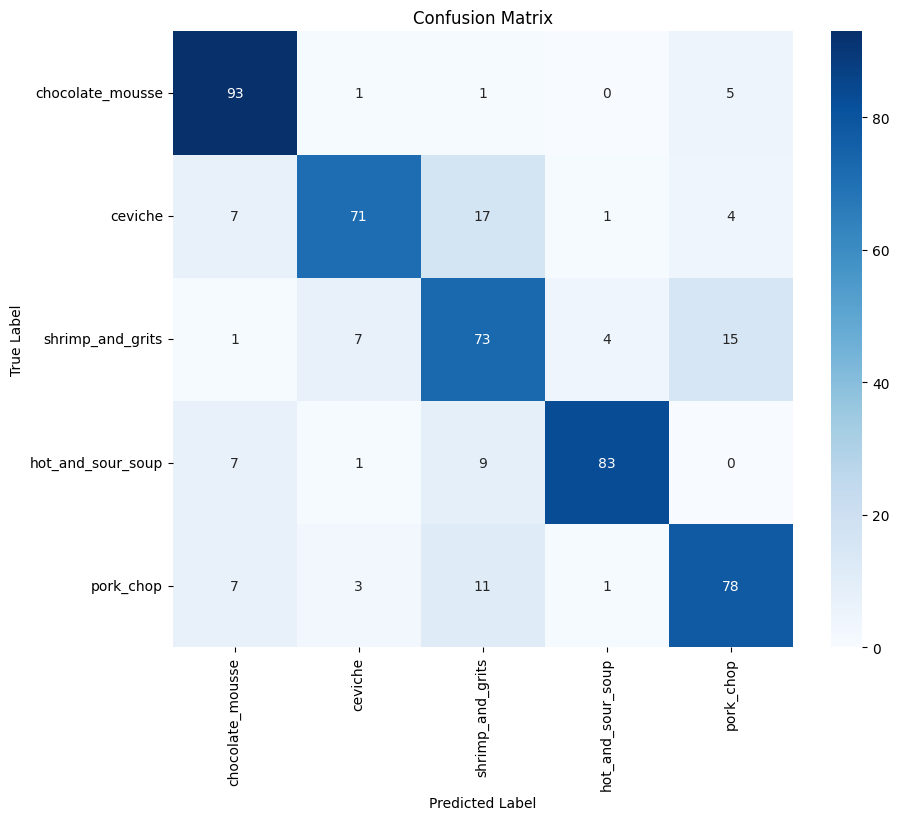


=== Runtime Performance ===
Initial Training Time: 994.94 seconds
Fine-Tuning Time: 3198.73 seconds


In [31]:
gen_report(model, test_generator, history, fine_tune_history, initial_training_time, fine_tuning_time)